<a href="https://colab.research.google.com/github/omerfguzel/global-ai-hub-dl-bootcamp/blob/main/training_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# To see which GPU has being used. Colab Pro offers Tesla-P100 as the best processor.
!nvidia-smi

Thu Oct  6 15:42:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import cv2
import os
from zipfile import ZipFile
import time
from datetime import datetime
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import random

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D, AveragePooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
# Unzipping the dataset file preprocessed_spectograms.zip

combined_faces_zip_path = "/content/drive/MyDrive/global-ai-hub-bootcamp/preprocessed_spectograms.zip"

with ZipFile(combined_faces_zip_path, 'r') as myzip:
    myzip.extractall()
    print('Done unzipping preprocessed_spectograms.zip')

Done unzipping preprocessed_spectograms.zip


In [4]:
df = pd.read_csv("/content/drive/MyDrive/global-ai-hub-bootcamp/cleaned_metadata.csv")
df.head()

,fold,classID,filename
0,5,3,/content/content/spectograms/3/100032-3-0-0.png
1,5,2,/content/content/spectograms/2/100263-2-0-117.png
2,5,2,/content/content/spectograms/2/100263-2-0-121.png
3,5,2,/content/content/spectograms/2/100263-2-0-126.png
4,5,2,/content/content/spectograms/2/100263-2-0-137.png


In [21]:
def model_generator(dim=256):
  # Defining the architecture of the sequential neural network.

  model = Sequential()

  # Input layer with 32 filters, followed by an AveragePooling2D layer.
  model.add(Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(dim, dim, 1)))    # 3rd dim = 1 for grayscale images.
  model.add(AveragePooling2D(pool_size=(2,2)))
  model.add(BatchNormalization())

  model.add(Conv2D(filters=64, kernel_size=3, activation='relu'))
  model.add(AveragePooling2D(pool_size=(2,2)))
  model.add(Dropout(0.125))
  model.add(BatchNormalization())

  model.add(Conv2D(filters=128, kernel_size=3, activation='relu'))
  model.add(AveragePooling2D(pool_size=(2,2)))
  model.add(Dropout(0.25))
  model.add(BatchNormalization())

  model.add(Conv2D(filters=256, kernel_size=3, activation='relu'))
  model.add(AveragePooling2D(pool_size=(2,2)))
  model.add(Dropout(0.5))
  model.add(BatchNormalization())

  model.add(GlobalAveragePooling2D())

  # One Dense layer with 132 nodes so as to taper down the no. of nodes from no. of outputs of GlobalAveragePooling2D layer above towards no. of nodes in output layer below (7).
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(BatchNormalization())

  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.25))
  model.add(BatchNormalization())

  # Output layer with 7 nodes (equal to the no. of classes).
  model.add(Dense(10, activation='softmax'))

  return model

In [15]:
# Defining a function to read the image, decode the image from given tensor and one-hot encode the image label class.

num_classes = 10

def _parse_function(filename, label):
    
    image_string = tf.io.read_file(filename)
    image_decoded = tf.io.decode_jpeg(image_string, channels=1)    # channels=1 to convert to grayscale.
    image_resized = tf.image.resize(image_decoded, [256, 256])
    # image_normalized = tf.image.per_image_standardization(image_resized)
    label = tf.one_hot(label, num_classes)

    return image_resized, label

In [16]:
def dataset_generator(i, batch_size):
  train_set = df[df['fold'] != i]
  X_train, y_train = train_set.filename, train_set.classID
  temp_set = df[df['fold'] == i]

  X_val, X_test, y_val, y_test = train_test_split(temp_set.filename, temp_set.classID,
                                                  test_size=0.4, random_state=42, stratify=temp_set.classID)
  
  train_filenames_tensor = tf.constant(list(X_train))
  train_labels_tensor = tf.constant(list(y_train))

  val_filenames_tensor = tf.constant(list(X_val))
  val_labels_tensor = tf.constant(list(y_val))

  test_filenames_tensor = tf.constant(list(X_test))
  test_labels_tensor = tf.constant(list(y_test))

    # Getting the dataset ready for the neural network.
  # Using the tensor vectors defined above, accessing the images in the dataset and passing them through the function defined above.

  train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames_tensor, train_labels_tensor))
  train_dataset = train_dataset.map(_parse_function)
  train_dataset = train_dataset.batch(batch_size)    # Same as batch_size hyperparameter in model.fit() below.

  val_dataset = tf.data.Dataset.from_tensor_slices((val_filenames_tensor, val_labels_tensor))
  val_dataset = val_dataset.map(_parse_function)
  val_dataset = val_dataset.batch(batch_size)    # Same as batch_size hyperparameter in model.fit() below.


  test_dataset = tf.data.Dataset.from_tensor_slices((test_filenames_tensor, test_labels_tensor))
  test_dataset = test_dataset.map(_parse_function)
  test_dataset = test_dataset.batch(batch_size)    # Same as batch_size hyperparameter in model.fit() below.

  return train_dataset, val_dataset, test_dataset, y_test

In [17]:
# Fitting the above created CNN model for 50 epochs.
def train_test(i,model,epochs,batch_size):
  checkpoint = ModelCheckpoint(filepath=f"/content/drive/My Drive/512-gray-urbansounds-fold{str(i)}-best_model.h5",
                  monitor='val_accuracy',
                  save_best_only=True,
                  save_weights_only=False,
                  verbose=2
                  )
  
  model_history = model.fit(train_dataset,
                                    batch_size=batch_size,
                                    validation_data=val_dataset,
                                    epochs=epochs,
                                    callbacks=[checkpoint],
                                    shuffle=False,
                                    verbose=2    # shuffle=False to reduce randomness and increase reproducibility
                                  )
  
  best_model = load_model(f"/content/drive/My Drive/512-gray-urbansounds-fold{str(i)}-best_model.h5")
  model_score = best_model.evaluate(test_dataset, verbose=0)
  best_loss = round(model_score[0], 3)
  best_accuracy = round(model_score[1], 3)

  model_pred = model.predict(test_dataset)
  model_pred = model_pred.argmax(axis=-1)
  conf_mat = confusion_matrix(y_test, model_pred)

  return model_history, best_accuracy, best_loss, conf_mat

In [9]:
# Defining a function to plot the confusion matrix in a grid for easier visualization.

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', export_as='confusion_matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=16)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Gerçek etiket', fontsize=14)
    plt.xlabel('Tahmin edilen etiket', fontsize=14)

In [22]:
accuracies = []
losses = []
conf_matrices = []
histories = []
for i in range(1,11):
  print(f"Training model on Fold-{i}")
  train_dataset, val_dataset, test_dataset, y_test= dataset_generator(i,batch_size=128)
  model = model_generator()
  model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
  model_history, best_accuracy, best_loss, conf_mat = train_test(i,model,epochs=100,batch_size=128)
  
  histories.append(model_history)
  accuracies.append(best_accuracy)
  losses.append(best_loss)
  conf_matrices.append(conf_mat)

Training model on Fold-1
Epoch 1/100

Epoch 1: val_accuracy improved from -inf to 0.27342, saving model to /content/drive/My Drive/512-gray-urbansounds-fold1-best_model.h5
62/62 - 12s - loss: 2.3841 - accuracy: 0.2050 - val_loss: 2.1332 - val_accuracy: 0.2734 - 12s/epoch - 186ms/step
Epoch 2/100

Epoch 2: val_accuracy did not improve from 0.27342
62/62 - 9s - loss: 2.1116 - accuracy: 0.2661 - val_loss: 2.3898 - val_accuracy: 0.1950 - 9s/epoch - 147ms/step
Epoch 3/100

Epoch 3: val_accuracy did not improve from 0.27342
62/62 - 9s - loss: 1.9864 - accuracy: 0.2952 - val_loss: 1.8420 - val_accuracy: 0.2696 - 9s/epoch - 147ms/step
Epoch 4/100

Epoch 4: val_accuracy did not improve from 0.27342
62/62 - 9s - loss: 1.8989 - accuracy: 0.3223 - val_loss: 2.3001 - val_accuracy: 0.2447 - 9s/epoch - 147ms/step
Epoch 5/100

Epoch 5: val_accuracy improved from 0.27342 to 0.36520, saving model to /content/drive/My Drive/512-gray-urbansounds-fold1-best_model.h5
62/62 - 10s - loss: 1.8258 - accuracy: 0

Training model on Fold-3
Epoch 1/100

Epoch 1: val_accuracy improved from -inf to 0.23243, saving model to /content/drive/My Drive/512-gray-urbansounds-fold3-best_model.h5
61/61 - 12s - loss: 2.3378 - accuracy: 0.2058 - val_loss: 2.3466 - val_accuracy: 0.2324 - 12s/epoch - 196ms/step
Epoch 2/100

Epoch 2: val_accuracy improved from 0.23243 to 0.28288, saving model to /content/drive/My Drive/512-gray-urbansounds-fold3-best_model.h5
61/61 - 10s - loss: 2.1192 - accuracy: 0.2635 - val_loss: 2.0517 - val_accuracy: 0.2829 - 10s/epoch - 156ms/step
Epoch 3/100

Epoch 3: val_accuracy improved from 0.28288 to 0.39279, saving model to /content/drive/My Drive/512-gray-urbansounds-fold3-best_model.h5
61/61 - 9s - loss: 1.9946 - accuracy: 0.2988 - val_loss: 1.7307 - val_accuracy: 0.3928 - 9s/epoch - 151ms/step
Epoch 4/100

Epoch 4: val_accuracy did not improve from 0.39279
61/61 - 9s - loss: 1.9237 - accuracy: 0.3204 - val_loss: 1.8594 - val_accuracy: 0.2829 - 9s/epoch - 149ms/step
Epoch 5/100

Epo

Training model on Fold-4
Epoch 1/100

Epoch 1: val_accuracy improved from -inf to 0.18519, saving model to /content/drive/My Drive/512-gray-urbansounds-fold4-best_model.h5
61/61 - 13s - loss: 2.3949 - accuracy: 0.1932 - val_loss: 3.0119 - val_accuracy: 0.1852 - 13s/epoch - 217ms/step
Epoch 2/100

Epoch 2: val_accuracy improved from 0.18519 to 0.24916, saving model to /content/drive/My Drive/512-gray-urbansounds-fold4-best_model.h5
61/61 - 9s - loss: 2.1261 - accuracy: 0.2605 - val_loss: 2.0093 - val_accuracy: 0.2492 - 9s/epoch - 150ms/step
Epoch 3/100

Epoch 3: val_accuracy improved from 0.24916 to 0.28451, saving model to /content/drive/My Drive/512-gray-urbansounds-fold4-best_model.h5
61/61 - 10s - loss: 1.9915 - accuracy: 0.2954 - val_loss: 2.1695 - val_accuracy: 0.2845 - 10s/epoch - 157ms/step
Epoch 4/100

Epoch 4: val_accuracy did not improve from 0.28451
61/61 - 9s - loss: 1.9143 - accuracy: 0.3153 - val_loss: 2.5296 - val_accuracy: 0.2357 - 9s/epoch - 149ms/step
Epoch 5/100

Epo

In [23]:
print(f"Average loss of 10-Fold is {sum(losses)/10}")
print(f"Average accuracy of 10-Fold is {sum(accuracies)*10}%")

Average loss of 10-Fold is 0.9299999999999999
Average accuracy of 10-Fold is 74.24%


Normalized confusion matrix


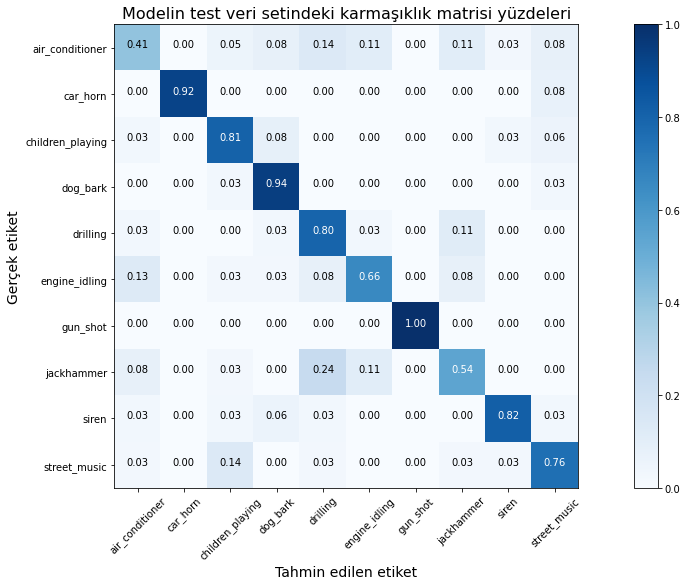

In [24]:
conf_mat_avg = (sum(conf_matrices)/10).astype(int)

cm_plot_labels = ['air_conditioner', 'car_horn','children_playing', 'dog_bark', 'drilling', 'engine_idling', 'gun_shot', 'jackhammer',
                  'siren', 'street_music']
plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat_avg, cm_plot_labels, normalize=True,
                      title="Modelin test veri setindeki karmaşıklık matrisi yüzdeleri")

plt.show()

Confusion matrix, without normalization


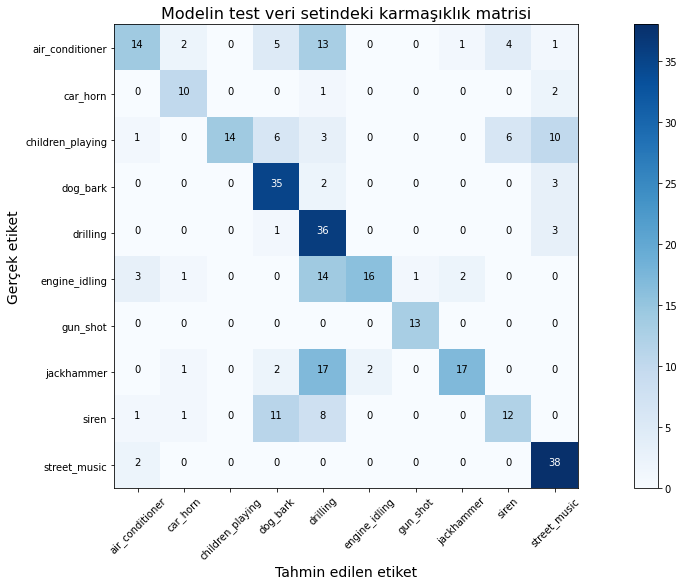

In [25]:
plt.figure(figsize=(16,8))
plot_confusion_matrix(conf_mat, cm_plot_labels, normalize=False,
                      title="Modelin test veri setindeki karmaşıklık matrisi")

plt.show()